<h1><center> Demonstration of the PyPortfolioOpt module on the club's portfolio </center></h1>
<h2><center>LSM Investment Club - Team Quant </center></h2>
<h3><center>Adrien </center></h3>

### Why use this module? 
I want to compare the empirical estimates of the portfolio team on the allocation of weights to each stock and try to optimize the portfolio in several ways and compare:
- Minimizing risk under a maximum return condition
- Maximizing return under a minimum risk condition
- Maximizing the Sharpe ratio under conditions

This kind of problem is easily reformulated as a convex optimization problem, and as we saw in optimization class, it's a well-behaved class of problems with certain properties regarding the existence of solutions, etc.

https://pyportfolioopt.readthedocs.io/en/latest/index.html

This module doesn't come out of nowhere, it has over 4500 stars on GitHub, its creator works as a trader at D.E Shaw (https://www.linkedin.com/in/robert-a-martin/), and it's the only recognized Python library for this kind of modeling/calculations.

### Portfolio Information

The information on the portfolio may not be up to date, but it reflects a historically significant portion of the club's assets, so the analysis remains relevant.

See https://docs.google.com/spreadsheets/d/1ADK8enoEoA7vzp9y66nytM0gFdPer38v/edit?gid=448484424#gid=448484424

In [1]:
import yfinance as yf
import numpy as np
tickers = [
    "AED.BR",       # Aedifica NV
    "AAPL",         # Apple Inc
    "BFIT.AS",      # Basic Fit NV
    "BX",           # Blackstone Inc
    "ENPH",         # Enphase Energy Inc
    "EVO.ST",       # Evolution AB (publ)
    "HFG.DE",       # Hellofresh SE
    "INRG.MI",      # iShares Global Clean Energy UCITS ETF USD (Dist)
    "HEAL.AS",      # iShares Healthcare Innovation UCITS ETF USD A
    "IESE.AS",      # iShares MSCI Europe SRI UCITS ETF EUR (Acc)
    "SGLN.L",       # iShares Physical Gold
    "MC.PA",        # LVMH Moet Hennessy Louis Vuitton SE
    "MA",           # Mastercard Inc
    "MRK",          # Merck & Co Inc
    "MSFT",         # Microsoft Corp
    "NESN.SW",      # Nestle SA
    "OGN",          # Organon & Co
    "SGM.F",        # STMicroelectronics NV
    "TEP.PA",       # Teleperformance SE
    "TCEHY",        # Tencent Holdings ADR
    "UMI.BR",       # Umicore SA
    "WLN.PA"        # Worldline SA
]

raw_weights = np.array([
    0.0348, 0.1431, 0.0172, 0.0347, 0.0173,
    0.0160, 0.0042, 0.0182, 0.0218, 0.0528,
    0.0933, 0.0838, 0.0623, 0.0554, 0.1395,
    0.0199, 0.0007, 0.0173, 0.0214, 0.0376,
    0.0070, 0.0031
]) # From the Google Docs file, excluding cash


actual_weights = raw_weights / np.sum(raw_weights)

start_date = "2022-10-25"
end_date = "2024-10-25"

df = yf.download(tickers, start=start_date, end=end_date)['Close'].dropna()
df.index = df.index.strftime('%Y-%m-%d') # Remove the time from the date

df.head


[*********************100%***********************]  22 of 22 completed


<bound method NDFrame.head of Ticker            AAPL     AED.BR    BFIT.AS          BX        ENPH  \
Date                                                                   
2022-10-25  152.339996  78.353767  30.620001   91.550003  265.589996   
2022-10-26  149.350006  75.569382  31.080000   92.739998  291.869995   
2022-10-27  144.800003  78.158371  30.559999   93.449997  306.079987   
2022-10-28  155.740005  76.155563  24.760000   93.180000  305.250000   
2022-10-31  153.339996  75.422829  25.500000   91.139999  307.000000   
...                ...        ...        ...         ...         ...   
2024-10-18  235.000000  63.000000  25.080000  172.360001   91.639999   
2024-10-21  236.479996  61.849998  23.980000  170.770004   90.419998   
2024-10-22  235.860001  60.950001  23.879999  168.500000   92.230003   
2024-10-23  230.759995  60.750000  23.860001  166.919998   78.470001   
2024-10-24  230.570007  60.700001  23.200001  169.660004   81.099998   

Ticker           EVO.ST  HEAL.AS 

In [2]:
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

mu = mean_historical_return(df) # Estimation of expected returns 
S = CovarianceShrinkage(df).ledoit_wolf() # Estimation of the covariance matrix 
# Ledoit-Wolf is useful for high dimensional matrices

---

## Classic Markowitz Portfolio Model (1952) / Mean-Variance Optimization

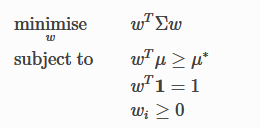

The image above shows the problem we are trying to solve: we need to minimize the risk of the portfolio, i.e., the objective function, based on the weight vector ww assigned to each stock such that:

    - The return of our portfolio is greater than a minimum value μ*, our target return.

    - The sum of the vector w is 1.

    - The weights are non-negative.

The package solves this problem for us with the following commands:

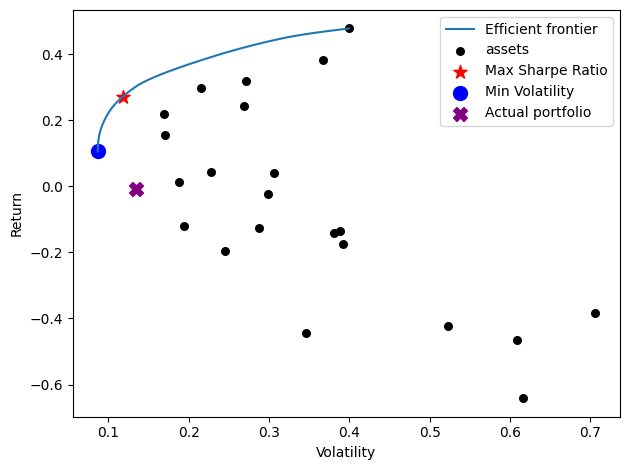

In [3]:
import matplotlib.pyplot as plt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import plotting # Here I had an issue, the plotting font was no longer available, so I had to delete a line from the base code
ef = EfficientFrontier(mu, S, weight_bounds = (0,1), solver = "MOSEK") # Here I had to get an academic trial license for the solver "Mosek", but you can use another one.

# We can also use max_quadratic_utility, efficient_risk (max return for a given risk), efficient_return (min volatility for a given return), and we can customize them too but it's complicated.

ef.max_sharpe() # risk_free_rate=0.02, default parameter
max_sharpe_weights = ef.clean_weights() # Cleans the weights to have clearer numbers, just aesthetic.
max_sharpe_return, max_sharpe_risk, max_sharpe_ratio = ef.portfolio_performance()

ef = EfficientFrontier(mu, S, weight_bounds = (0,1)) # We need to redefine the EfficientFrontier for each manipulation (resolution) on it.
ef.min_volatility()
min_volatility_weights = ef.clean_weights()
min_vol_return, min_vol_risk, _ = ef.portfolio_performance()

# Return and volatility of the current portfolio
actual_return = np.dot(actual_weights, mu)  # Expected portfolio return
actual_volatility = np.sqrt(np.dot(actual_weights.T, np.dot(S, actual_weights)))

ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))  
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax = ax, show_assets = True)
ax.scatter(max_sharpe_risk, max_sharpe_return, marker="*", color="r", s=100, label="Max Sharpe Ratio")
ax.scatter(min_vol_risk, min_vol_return, marker="o", color="b", s=100, label="Min Volatility")
ax.scatter(actual_volatility, actual_return, marker="X", color="purple", s=100, label="Actual portfolio")
plt.legend()
plt.show()

In [4]:
min_volatility_weights

OrderedDict([('AAPL', 0.03046),
             ('AED.BR', 0.01474),
             ('BFIT.AS', 0.0),
             ('BX', 0.0),
             ('ENPH', 0.0),
             ('EVO.ST', 0.01318),
             ('HEAL.AS', 0.12014),
             ('HFG.DE', 0.0),
             ('IESE.AS', 0.12818),
             ('INRG.MI', 0.02268),
             ('MA', 0.06543),
             ('MC.PA', 0.0),
             ('MRK', 0.12711),
             ('MSFT', 0.04278),
             ('NESN.SW', 0.13973),
             ('OGN', 0.0),
             ('SGLN.L', 0.28057),
             ('SGM.F', 0.0),
             ('TCEHY', 0.00633),
             ('TEP.PA', 0.00653),
             ('UMI.BR', 0.00213),
             ('WLN.PA', 0.0)])

In [5]:
max_sharpe_weights

OrderedDict([('AAPL', 0.01639),
             ('AED.BR', 0.0),
             ('BFIT.AS', 0.0),
             ('BX', 0.0345),
             ('ENPH', 0.0),
             ('EVO.ST', 0.0),
             ('HEAL.AS', 0.0),
             ('HFG.DE', 0.0),
             ('IESE.AS', 0.0986),
             ('INRG.MI', 0.0),
             ('MA', 0.20755),
             ('MC.PA', 0.0),
             ('MRK', 0.02197),
             ('MSFT', 0.11685),
             ('NESN.SW', 0.0),
             ('OGN', 0.0),
             ('SGLN.L', 0.39862),
             ('SGM.F', 0.0),
             ('TCEHY', 0.10553),
             ('TEP.PA', 0.0),
             ('UMI.BR', 0.0),
             ('WLN.PA', 0.0)])

---

### Observations

The fact that our current portfolio (in purple) is not on the optimal frontier shows that, according to our data, we could have a higher return for the same risk, a lower risk for a higher return, and any average of the portfolios on the frontier, so it's a sub-optimal portfolio! The only thing to adjust is the start date, but just because we made a positive return over a given period doesn't mean we shouldn't reconsider our current portfolio choice.

We could say that many stocks are set to 0, so two things: the first is that it's possible to introduce constraints, i.e., I want my CLUB to allocate x% in ETFs, y% in stocks, but how to choose these %, it would be arbitrary, if an ETF performs better, why should we penalize our portfolio with stocks just because we analyzed a lousy company? Then, it's possible according to the package to introduce "L2 regularization" conditions, roughly it introduces an objective function that will penalize having stocks close to 0, to push for diversification.

Of course, there are limitations, gold (SGLN.L) has risen over the last 2 years due to the COVID + UKRAINE sequence that panicked some markets, so it may not be a good solution to put so much in it today, it's just that according to our data, going back 2 years, it seems like a good idea. It's highly subject to interpretation, we could introduce more constraints, this model is very basic, no real notion of prediction, even though it can be impressive.

---

### Example of L2 Regularization

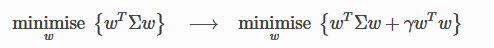

Preferably $\gamma \geq 1$ and can be much larger than 1 if we have more than 20 tickers.

---

## Semivariance Method

See https://www.hudsonbaycapital.com/documents/FG/hudsonbay/research/599440_paper.pdf, especially page 24 for the precise formulation in optimization.

Key point: We use the semi-variance which only captures data below the mean, because we want to have volatility upwards to increase our gain.

Negative point of the method: Many artifices are used by the solver to make the problem feasible, except that we have to stick to shorter periods because it introduces a number of variables depending on the number of days in the df on financial data. It's less stable because we can't calculate the Sharpe ratio so we have to use the Sortino ratio (the idea is the same as the Sharpe), but comparing the two wouldn't really make sense.

c:\Users\porti\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:354: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add an explicit dependency on ECOS or switch to our new
    default solver, Clarabel, by either not specifying a solver argument
    or specifying ``solver=cp.CLARABEL``.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


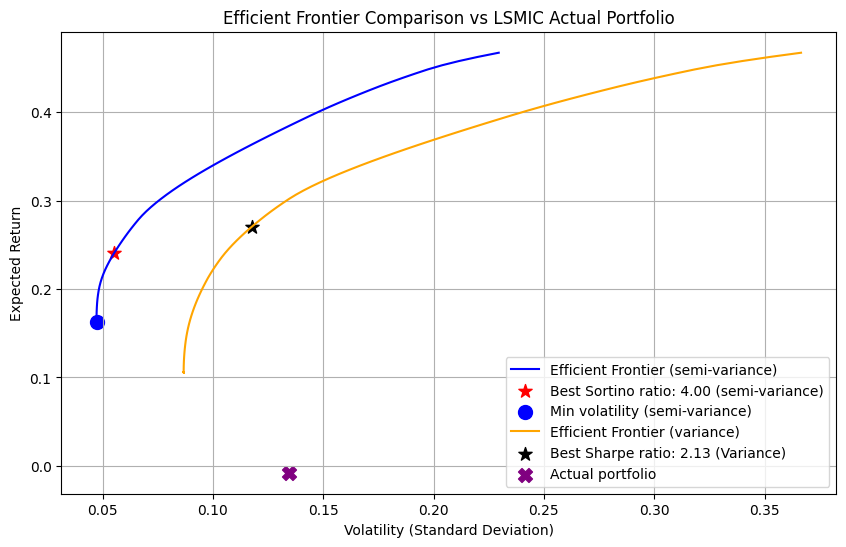

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import expected_returns, EfficientFrontier, EfficientSemivariance

# Same code as before but using semi-variance

mu = expected_returns.mean_historical_return(df)
historical_returns = expected_returns.returns_from_prices(df)
target_returns = np.linspace(0, mu.max()-0.01, 100)

es = EfficientSemivariance(mu, historical_returns, weight_bounds=(0, 1))  # EfficientSemivariance must be redefined at each operation (optimization).
risks_es = []
returns_es = []
max_sortino_es = -np.inf

for target_return in target_returns:
    es = EfficientSemivariance(mu, historical_returns, weight_bounds=(0, 1), solver='ECOS')
    es.efficient_return(target_return)
    portfolio_return, portfolio_risk, sortino_ratio = es.portfolio_performance()
    risks_es.append(portfolio_risk)
    returns_es.append(portfolio_return)
    if sortino_ratio > max_sortino_es:
        max_sortino_es = sortino_ratio
        best_sortino_return = portfolio_return
        best_sortino_risk = portfolio_risk

# Computation of the traditional efficient frontier
mu = expected_returns.mean_historical_return(df)  # Expected return estimation
S = CovarianceShrinkage(df).ledoit_wolf()  # Covariance matrix estimation, Ledoit-Wolf is useful for high-dimensional matrices
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
risks_ef = []
returns_ef = []

for target_return in target_returns:
    ef.efficient_return(target_return)
    portfolio_return, portfolio_risk, _ = ef.portfolio_performance()
    risks_ef.append(portfolio_risk)
    returns_ef.append(portfolio_return)

# Plotting the two efficient frontiers
plt.figure(figsize=(10, 6))
plt.plot(risks_es, returns_es, label="Efficient Frontier (semi-variance)", color="blue")
plt.scatter(best_sortino_risk, best_sortino_return, marker="*", color="red", s=100, 
            label="Best Sortino ratio: {:.2f} (semi-variance)".format(max_sortino_es))
es = EfficientSemivariance(mu, historical_returns, weight_bounds=(0, 1))
es.min_semivariance()
min_volatility_weights = es.clean_weights()
min_vol_return, min_vol_risk, _ = es.portfolio_performance()
plt.scatter(min_vol_risk, min_vol_return, marker="o", color="b", s=100, label="Min volatility (semi-variance)")

plt.plot(risks_ef, returns_ef, label="Efficient Frontier (variance)", color="orange")
plt.scatter(max_sharpe_risk, max_sharpe_return, marker="*", color="black", s=100, label="Best Sharpe ratio: {:.2f} (Variance)".format(max_sharpe_ratio))

actual_return = np.dot(actual_weights, mu)  # Expected portfolio return
actual_volatility = np.sqrt(np.dot(actual_weights.T, np.dot(S, actual_weights)))
plt.scatter(actual_volatility, actual_return, marker="X", color="purple", s=100, label="Actual portfolio")

# Graph customization
plt.title("Efficient Frontier Comparison vs LSMIC Actual Portfolio")
plt.xlabel("Volatility (Standard Deviation)")
plt.ylabel("Expected Return")
plt.legend()
plt.grid()
plt.show()

Once again, we want our portfolio to be not at all optimal according to these two types of measures, while also considering the issues related to the time scale and the data.

--- 

## Method on Expected Shortfall

Without going into details here, we consider another portfolio optimization approach that aims to minimize the expected shortfall, which can be quite interesting for the club targeting the medium term. The problem can be approximately solved through a linear optimization model provided by the library.

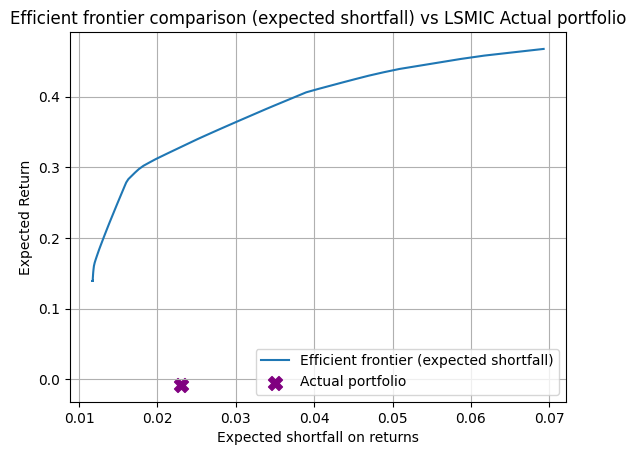

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import expected_returns,EfficientCVaR

confidence_level = 0.99

mu = expected_returns.mean_historical_return(df)
historical_returns = expected_returns.returns_from_prices(df)
target_returns = np.linspace(0, mu.max()-0.01, 100)
ES_ExpShort = []
returns_ExpShort = []

for target_return in target_returns:
    es = EfficientCVaR(mu, historical_returns, weight_bounds=(0, 1), beta = confidence_level) # Ici le niveau de confiance (beta) est de base à 0.95
    es.efficient_return(target_return)
    portfolio_return,portfolio_ES= es.portfolio_performance()
    ES_ExpShort.append(portfolio_ES)
    returns_ExpShort.append(portfolio_return)

plt.plot(ES_ExpShort, returns_ExpShort, label = "Efficient frontier (expected shortfall)")


VaR = np.quantile(historical_returns.dot(actual_weights), (1-confidence_level))
ActualExpectedShortfall = -1*historical_returns.dot(actual_weights)[historical_returns.dot(actual_weights) <= VaR].mean()
plt.scatter(ActualExpectedShortfall, actual_return, marker="X", color="purple", s=100, label="Actual portfolio")

plt.title("Efficient frontier comparison (expected shortfall) vs LSMIC Actual portfolio")
plt.xlabel("Expected shortfall on returns")
plt.ylabel("Expected Return")
plt.legend()
plt.grid()
plt.show()


---

## Method on the Mean Drawdown at Risk (Equivalent to Expected Shortfall for VaR)

Here, it's another metric. See [Wikipedia on Drawdown](https://en.wikipedia.org/wiki/Drawdown_(economics)) and also the article https://www.math.columbia.edu/~chekhlov/IJTheoreticalAppliedFinance.8.1.2005.pdf, modeling on page 24 of this paper, where page 26 is interesting because it proves that the frontier is a concave curve.

Compared to VaR, for each time $t$, we look at the highest peak on the left and subtract the current price value. The idea of keeping the drawdown below a certain threshold is to protect oneself both financially against heavy losses and psychologically. If we observe a significant drawdown, we might be tempted to withdraw our investment to avoid even heavier losses. The key idea is that a 100% increase is needed to recover one's capital from a 50% loss.

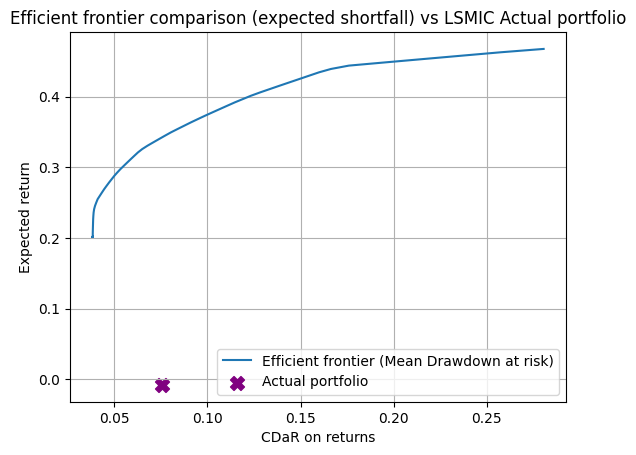

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import expected_returns,EfficientCDaR

confidence_level = 0.99

mu = expected_returns.mean_historical_return(df)
historical_returns = expected_returns.returns_from_prices(df)
target_returns = np.linspace(0, mu.max()-0.01, 100)
CDaR_Drawdown = []
returns_Drawdown = []

for target_return in target_returns:
    es = EfficientCDaR(mu, historical_returns, weight_bounds=(0, 1), beta = confidence_level) # Ici le niveau de confiance (beta) est de base à 0.95
    es.efficient_return(target_return)
    portfolio_return,portfolio_CDaR= es.portfolio_performance()
    CDaR_Drawdown.append(portfolio_CDaR)
    returns_Drawdown.append(portfolio_return)

plt.plot(CDaR_Drawdown, returns_Drawdown, label = "Efficient frontier (Mean Drawdown at risk)")

portfolio_returns = historical_returns.dot(actual_weights)
cumulative_returns = (1 + portfolio_returns).cumprod()
peak = cumulative_returns.cummax()
drawdowns = (cumulative_returns - peak) / peak
VaR_drawdown = np.quantile(drawdowns, confidence_level)
ActualCDaR = -drawdowns[drawdowns <= VaR_drawdown].mean()

plt.scatter(ActualCDaR, actual_return, marker="X", color="purple", s=100, label="Actual portfolio")

plt.title("Efficient frontier comparison (expected shortfall) vs LSMIC Actual portfolio")
plt.xlabel("CDaR on returns")
plt.ylabel("Expected return")
plt.legend()
plt.grid()
plt.show()


---

The library also implements Black-Litterman, but it's more complicated to present a concrete example, as the technique relies on specific investor expectations regarding certain assets.

A simple implementation example is available here:
https://github.com/thk3421-models/cardiel

Otherwise, check out

https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html

https://en.wikipedia.org/wiki/Black%E2%80%93Litterman_model

---

In conclusion, the club's portfolio is not optimal, and I can provide portfolio combinations that are much more optimal while respecting a given budget, such as:

In [9]:
from pypfopt import EfficientFrontier, DiscreteAllocation, expected_returns

mu = expected_returns.mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf() 
ef = EfficientFrontier(mu, S,weight_bounds=(0, 1))

raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights() 

portfolio_value = 20000 # Based on 20.000€
latest_prices = df.iloc[-1]  # Last prices at end period

da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=portfolio_value)
allocation, leftover = da.lp_portfolio()

print("Allocation in whole shares:", allocation)
print("Remaining resources:", leftover)


Allocation in whole shares: {'AAPL': 1, 'BX': 4, 'HEAL.AS': 3, 'HFG.DE': 2, 'IESE.AS': 28, 'INRG.MI': 3, 'MA': 8, 'MRK': 4, 'MSFT': 5, 'OGN': 1, 'SGLN.L': 2, 'TCEHY': 39, 'UMI.BR': 1, 'WLN.PA': 4}
Remaining resources: 87.89299878259408


c:\Users\porti\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [10]:
mu = expected_returns.mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf() 
ef = EfficientFrontier(mu, S,weight_bounds=(0, 1))

raw_weights = ef.min_volatility()
cleaned_weights = ef.clean_weights() 

portfolio_value = 20000 # Based on 20.000€
latest_prices = df.iloc[-1]  # Last prices at end period

da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=portfolio_value)
allocation, leftover = da.lp_portfolio()

print("Allocation in whole shares:", allocation)
print("Remaining resources:", leftover)

Allocation in whole shares: {'AAPL': 3, 'AED.BR': 5, 'HEAL.AS': 328, 'IESE.AS': 37, 'INRG.MI': 63, 'MA': 3, 'MRK': 24, 'MSFT': 2, 'NESN.SW': 33, 'SGLN.L': 1, 'TCEHY': 2, 'TEP.PA': 1, 'UMI.BR': 3}
Remaining resources: 1552.064015761869


c:\Users\porti\AppData\Local\Programs\Python\Python312\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


And I can also do this by enforcing conditions such as 40% ETFs, 60% stocks, etc.